In [1]:
import tensorflow as tf
# current processing
tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import Model, layers
from keras.models import Sequential
from keras.layers import preprocessing
from keras.utils import plot_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import librosa
import librosa.display

import os
import time
import itertools
import shutil
import cv2
import zipfile

from sklearn.preprocessing import LabelEncoder
from IPython import get_ipython
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

2.10.0


In [2]:
name = 'task_2.ipynb'

path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

random_state_global = 42

pathfinal = path + 'model_history/part_b/'
pathfinal2 = path + 'model_images/'
weightPath = path + 'model_history/part_b/weights/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4

checkpoint_path = pathfinal+'weights/checkpoint'

In [3]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()
  
unzip_data(f"{path}CV_Data.zip")

In [4]:
def delete_folder_contents(path_erase):
    '''
    take path to erase all data present on it
    '''
    folder_name = path_erase
    # Get all files in the folder
    files = os.listdir(folder_name)

    # Loop through the files and delete them
    for file in files:
        if(file == 'weights'):
            continue
        file_path = os.path.join(folder_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
# delete_folder_contents(pathfinal)
delete_folder_contents(pathfinal2)

### Data Loading

In [5]:
class_names = ['ba', 'ne', 'ni','paa', 're']
train_X = []
len_X = [] # later sequence changed
train_Y = []

test_X = []
test_Y = []
len_Y = [] # later sequence changed

l0 = path+'CV_Data'
totalFiles=0
train_files = 0
test_files = 0
for l1 in os.listdir(l0):
    if(l1 in class_names):
        ctrain=0
        ctest=0
        f1 = os.path.join(l0, l1)
        for l2 in os.listdir(f1):
            if(l2=='.DS_Store'):
                continue
            f2 = os.path.join(f1, l2)
            flag = False
            for l3 in os.listdir(f2):
                if(l3=='.DS_Store'):
                    continue
                if(flag==False):
                    if(l2 == 'Train'):
                        train_files+=len(os.listdir(f2))
                    else:
                        test_files+=len(os.listdir(f2))
                    totalFiles+=len(os.listdir(f2))
                    print(f'{l1} length: {len(os.listdir(f2))}, {l2}')
                flag=True
                f3 = os.path.join(f2, l3)
                with open(f3, 'r') as f:
                    lines = f.readlines()
                    mfcc_data = [list(map(float, line.strip().split(' '))) for line in lines]
                    length = len(mfcc_data)
                    if(l2 == 'Train' and ctrain<300):
                        ctrain+=1
                        train_X.append(mfcc_data)
                        train_Y.append(l1)
                        len_X.append(length)
                    elif(ctest<50):
                        ctest+=1
                        test_X.append(mfcc_data)
                        test_Y.append(l1)
                        len_Y.append(length)

print(f'Total files: {totalFiles}, Training Files {train_files}, Testing Files {test_files}')

def suffleData(list1, list2, random_state_global):
    np.random.seed(random_state_global)
    # Combine the lists using zip()
    combined = list(zip(list1, list2))
    # Shuffle the combined list
    np.random.shuffle(combined)

    # Unzip the shuffled list
    shuffled_list1, shuffled_list2 = zip(*combined)
    return shuffled_list1, shuffled_list2

train_X, train_Y = suffleData(train_X, train_Y, random_state_global)
test_X, test_Y = suffleData(test_X, test_Y, random_state_global)

train_M_Y = LabelEncoder().fit_transform(train_Y)
test_M_Y = LabelEncoder().fit_transform(test_Y)
# maximum_sequence_length = max(np.max(len_X), np.max(len_Y))
print(class_names)
class_ind = LabelEncoder().fit_transform(class_names)
print(class_ind)
print(f'Sequence length range {min(np.min(len_X), np.min(len_Y))} to {max(np.max(len_X), np.max(len_Y))}')

ni length: 47, Test
ni length: 186, Train
ba length: 72, Test
ba length: 290, Train
ne length: 243, Test
ne length: 970, Train
paa length: 77, Test
paa length: 307, Train
re length: 52, Test
re length: 208, Train
Total files: 2452, Training Files 1961, Testing Files 491
['ba', 'ne', 'ni', 'paa', 're']
[0 1 2 3 4]
Sequence length range 7 to 78


In [6]:
len(train_X), len(test_X)

(1284, 247)

### Frequency of seq length

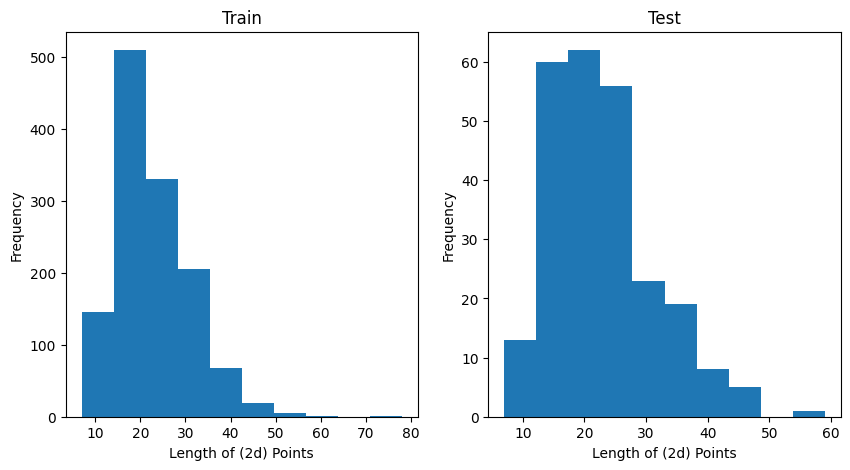

In [7]:
maximum_sequence_length = 50
mask_value = -2.0 ## because dataset do not have -2 value
fig,ax = plt.subplots(1,2, figsize=(10, 5))
ax = ax.reshape(-1)
for i in range(2):
    ax[i].hist(len_X if i==0 else len_Y)
    ax[i].set_title('Train' if i==0 else 'Test')
    ax[i].set_xlabel('Length of (2d) Points')
    ax[i].set_ylabel('Frequency')

### Visualizing Data

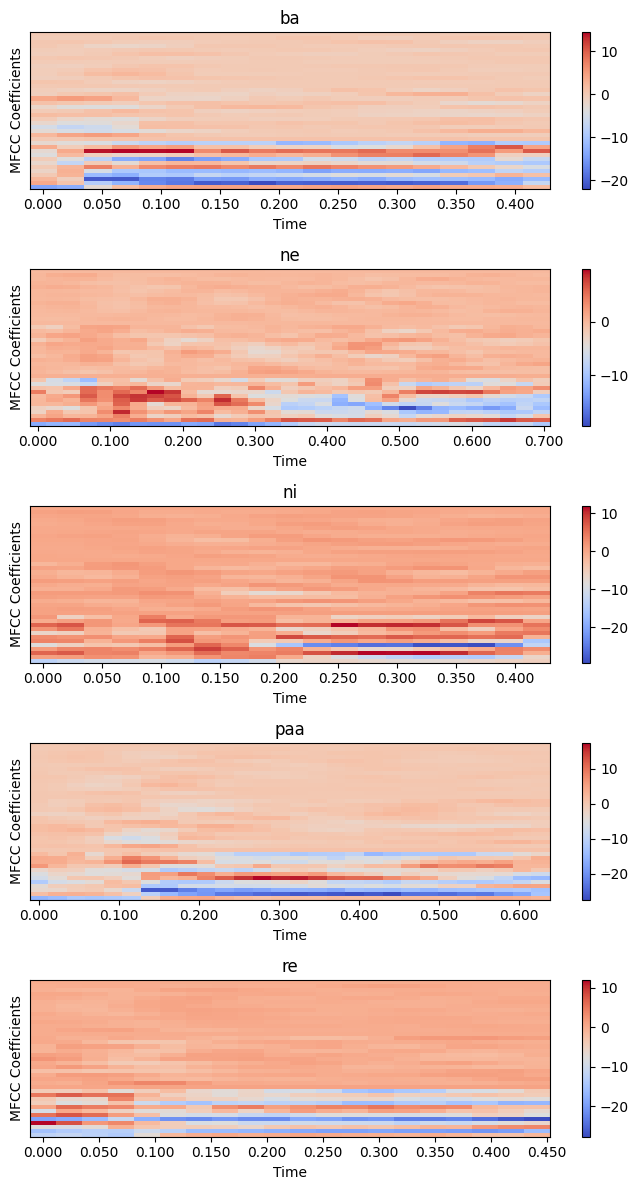

In [8]:
def plot_data(data_X, data_Y):
    sorted_lists = sorted(zip(data_Y, data_X))
    data_Y, data_X = zip(*sorted_lists)
    fig, ax = plt.subplots(5,1, figsize=(7, 12))
    ax = ax.reshape(-1)
    c=0
    cl=0
    mid=2
    colors = ['r', 'g', 'b', 'y', 'm']
    for i, ele in enumerate(data_Y):
        if(ele==cl):
            im = librosa.display.specshow(np.array(data_X[i]).T, x_axis='time',ax=ax[c])
            fig.colorbar(im, ax=ax[c])
            ax[c].set_title(f'{class_names[cl]}')
            ax[c].set_ylabel('MFCC Coefficients')
            ax[c].set_xlabel('Time')
            c+=1
            cl+=1
            if(c==5):
                break
    plt.tight_layout()
    plt.show()         

plot_data(train_X, train_M_Y)

### Functions

In [9]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_Y, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)
    

def inferences(df_model_history, model, data_X, data_Y):
    print(f'Training Accuracy for model: {df_model_history["accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Validation Accuracy for model: {df_model_history["val_accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Test Accuracy for model: {model.evaluate(data_X, data_Y, verbose=0)[1]*100:.2f}%')

    df_model_history.plot(title="Accuracy / Loss vs Epoch", xlabel='Epoch', ylabel='Accuracy / Loss')
    plt.show()
    
    df_model_history['loss'].plot(title="Average training error vs epochs", xlabel='Epoch', ylabel='Loss')
    plt.show()

def makingPredictionWithCM(model, data_X, data_Y, class_names):
    y_prob_a = model.predict(data_X, verbose=0)
    y_pred_a = y_prob_a.argmax(axis=1)
    make_confusion_matrix(data_Y, y_pred_a, class_names)

model_arch_list = []
def plottingModel(model):
    plot_model(model,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)
    img = plt.imread(f'model_images/model.png')
    model_arch_list.append(img)
    plt.figure(figsize=(5, 10))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

def showResults(model, history, data_X, data_Y, class_names):
    inferences(history, model, data_X, data_Y)
    makingPredictionWithCM(model, data_X, data_Y, class_names)
    # plottingModel(model)

In [10]:
def get_data_along_axis_0(data):
    return [sublist[0] for sublist in data]

# Example usage
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
result = get_data_along_axis_0(data)
print(result)

[1, 4, 7]


In [11]:
from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

# x = apply_minmax_scaler(train_X[0])

In [12]:


def minMaxPreprocessing(data):
    new_data = []
    n = len(data)
    for i in range(n):
        scaled_data = apply_minmax_scaler(data[i])
        new_data.append(scaled_data.tolist())
    return new_data

train_M_X = minMaxPreprocessing(train_X)
test_M_X = minMaxPreprocessing(test_X)
# plot_data(train_M_X, train_M_Y)

### Padding Sequence

In [13]:
def paddingSequence(data_X, maxlen=maximum_sequence_length):
    data_X = keras.preprocessing.sequence.pad_sequences(data_X, maxlen=maximum_sequence_length, padding='post', value=mask_value, dtype='float32')
    return data_X

train_M_X = paddingSequence(train_M_X)
test_M_X = paddingSequence(test_M_X)
np.min(train_M_X), np.max(train_M_X), np.min(test_M_X), np.max(test_M_X)

(-2.0, 1.0, -2.0, 1.0)

### Callbacks

In [14]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving()

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience= 10,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  verbose=1)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True)

### Building a RNN,LSTM Model

In [15]:
train_M_X.shape, test_M_X.shape

((1284, 50, 39), (247, 50, 39))

In [16]:
tf.random.set_seed(42)
input_shape = (train_M_X.shape[1], train_M_X.shape[2])
model_1 = Sequential()
model_1.add(layers.Input(shape=input_shape))
model_1.add(layers.Masking(mask_value=mask_value))
model_1.add(layers.GRU(64, return_sequences=True))
model_1.add(layers.GRU(32, return_sequences=True))
model_1.add(layers.GRU(16))
model_1.add(layers.Dense(5, activation='softmax'))

# # Train the RNN
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 50, 39)            0         
                                                                 
 gru (GRU)                   (None, 50, 64)            20160     
                                                                 
 gru_1 (GRU)                 (None, 50, 32)            9408      
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 32,053
Trainable params: 32,053
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Evaluate the model_1 initial losses
initial_train_loss, initial_train_acc = model_1.evaluate(train_M_X, train_M_Y, verbose=0)
initial_valid_loss, initial_valid_acc = model_1.evaluate(test_M_X, test_M_Y, verbose=0)

history_1 = model_1.fit(train_M_X, train_M_Y, 
                validation_data=(test_M_X, test_M_Y),
                callbacks=[HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), 
                                checkpoint_callback,
                                early_stopping_cb],
                batch_size=batch_size_val, epochs=epoch_val, verbose=1)

2023-05-19 00:25:18.244924: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/3000
41/41 [==============================] - 6s 32ms/step - loss: 1.4741 - accuracy: 0.3910 - val_loss: 1.3288 - val_accuracy: 0.4211
Epoch 2/3000
41/41 [==============================] - 1s 30ms/step - loss: 1.1243 - accuracy: 0.5514 - val_loss: 0.9977 - val_accuracy: 0.6032
Epoch 3/3000
41/41 [==============================] - 1s 32ms/step - loss: 0.8987 - accuracy: 0.6316 - val_loss: 0.9254 - val_accuracy: 0.6154
Epoch 4/3000
41/41 [==============================] - 1s 34ms/step - loss: 0.7982 - accuracy: 0.6963 - val_loss: 0.9328 - val_accuracy: 0.6113
Epoch 5/3000
41/41 [==============================] - 1s 33ms/step - loss: 0.7214 - accuracy: 0.7282 - val_loss: 0.8051 - val_accuracy: 0.6923
Epoch 6/3000
41/41 [==============================] - 1s 33ms/step - loss: 0.6519 - accuracy: 0.7562 - val_loss: 0.7618 - val_accuracy: 0.7085
Epoch 7/3000
41/41 [==============================] - 1s 34ms/step - loss: 0.6215 - accuracy: 0.7710 - val_loss: 0.7989 - val_accuracy: 0.6964

KeyboardInterrupt: 

In [ ]:
model_1.load_weights(checkpoint_path)
# df_history_1 = pd.read_csv(f'{pathfinal}sequential_3_19.csv')
df_history_1 = pd.DataFrame(history_1.history)
showResults(model_1, df_history_1, test_M_X, test_M_Y, class_names)
plot_model(model_1,to_file=f'{path}model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True, dpi=999)

In [ ]:
delete_folder_contents(pathfinal2)
get_ipython().system('osascript -e \'tell application "System Events" to keystroke "s" using command down\'')
get_ipython().system(f'jupyter nbconvert {name} --to python')